In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

## Functions:

### L1_optimize

In [3]:
from scipy.optimize import minimize

# The compact optimizer
def L1_optimize(y, D, lambds ,sign = 1.0, options={'disp': True}):
    '''
    This function gives the L1 regularized quadratic optimization of function 
    0.5*||y-x||_2^2 + lambds*||Dx||_1 
    
    Inputs:
    y: N*1 column vector
    D: k*N L1 regularized term
    lambds: a list of k numbers
    sign: 1. means minimize, -1. means maximize
    '''
    Q = D.dot(D.T)
    
    def func(v, sign):
        """ Objective function """
        K = D.T.dot(v)
        return sign*(0.5*K.T.dot(K) - y.T.dot(K))

    def func_deriv(v, sign):
        """ Derivative of objective function """
        return sign*(v.T.dot(Q) - y.T.dot(D.T))

    v = np.zeros([D.shape[0],1])
    
    bds = [[-lambds[i], lambds[i]] for i in range(len(v))]
    
    res = minimize(func, v, args=(sign,), jac=func_deriv,
                   bounds = bds, method='SLSQP', options= options)

    return y - D.T.dot(res.x)[:,np.newaxis]

### L1_Filters

In [4]:
from scipy.sparse import coo_matrix

def C_matrix(l):
    '''
    Get a sparse C matrix
    '''
    row = np.hstack([np.arange(0, l-1), np.arange(0, l-1)])
    col = np.hstack([np.arange(0, l-1), np.arange(1, l)])
    data = np.hstack([-np.ones(l-1), np.ones(l-1)])
    
    return coo_matrix((data, (row, col)), shape=(l-1, l))


def T_matrix(l):
    '''
    Get a sparse T matrix
    '''
    row  = np.hstack([np.arange(0, l-2), np.arange(0, l-2), np.arange(0, l-2)])
    col  = np.hstack([np.arange(0, l-2), np.arange(1, l-1), np.arange(2, l)])
    data = np.hstack([np.ones(l-2), -2*np.ones(l-2), np.ones(l-2)])
    
    return coo_matrix((data, (row, col)), shape=(l-2, l))


def L1_C_Filter(y, lambd, options={'disp': True}):
    '''
    L1_C_Filter
    
    Inputs:
    y: N*1 column vector
    lambd: a number
    '''
    D = C_matrix(len(y))
    lambds = lambd*np.ones(D.shape[0])
    return L1_optimize(y, D.toarray(), lambds , 1.0, options)


def L1_T_Filter(y, lambd, options={'disp': True}):
    '''
    L1_T_Filter
    
    Inputs:
    y: N*1 column vector
    lambd: a number
    '''
    D = T_matrix(len(y))
    lambds = lambd*np.ones(D.shape[0])
    return L1_optimize(y, D.toarray(), lambds , 1.0, options)


def L1_TC_Filter(y, lambd1, lambd2, options={'disp': True}):
    '''
    L1_TC_Filter
    
    Inputs:
    y: N*1 column vector
    lambd1, lambd2: a number
    '''
    D1 = C_matrix(len(y))
    D2 = T_matrix(len(y))
    lam1 = np.ones(len(y)-1)*lambd1
    lam2 = np.ones(len(y)-2)*lambd2
    lambds = np.hstack([lam1, lam2])
    D = np.vstack([D1.toarray(), D2.toarray()])
    
    return L1_optimize(y, D, lambds , 1.0, options)

### Lambda_Getters

In [5]:
def Get_T_lambda(y):
    """
    Get the estimated lambda_max for L1_T_Filter
    """
    D = T_matrix(len(y)).toarray()
    return np.max(np.abs(np.linalg.solve(D.dot(D.T), D.dot(y))))

def Get_C_lambda(y):
    """
    Get the estimated lambda_max for L1_C_Filter
    """
    D = C_matrix(len(y)).toarray()
    return np.max(np.abs(np.linalg.solve(D.dot(D.T), D.dot(y))))


### CV_Lambda

In [6]:
def CV_Lambda(y, T1, T2, n, L1_Filter, Lambda_Getter, options ={'disp': False}):
    """
    Get the optimal lambda using the cross validation procedure
    
    Inputs:
    y: signal
    T1 > T2: training periods > validating period
    n: the number of lambda values tested
    L1_Filter: function pointer to L1_Filter
    Lambda_Getter: function pointer to Lambda_Getter
    """
    m = len(y)/T2
    p = (len(y)-T2)/T1
    
    lambds = np.array([Lambda_Getter(y[i*T2: (i+1)*T2]) for i in range(m)])
    lam_m = np.mean(lambds)
    sig_lambd = np.std(lambds)
    
    lam1 = lam_m - 2*sig_lambd
    lam2 = lam_m + 2*sig_lambd
    
    print "lambda is in the range [%f, %f]" %(lam1, lam2)
    err_lam = np.zeros(n+1)
    if lam1<0:
        lam1 = lam2/10
    for j in range(n+1):
        lambd = lam1*(lam2/lam1)**(j*1./n)
        err = np.zeros(p)
        for k in range(p):
            #print lambd
            x = L1_Filter(y[k*T1: (k+1)*T1], lambd, options)
            dx = x[-1] - x[-2]
            err[k]= np.sum((y[(k+1)*T1: (k+1)*T1+T2] \
                            - np.linspace(x[-1]+dx, x[-1]+T2*dx, T2))**2)
        err_lam[j] = np.mean(err)
    ind = np.argmin(err_lam)
    
    lam_res = lam1*(lam2/lam1)**(ind*1./n)
    
    return lam_res
    

### Two_Trend_Predict

In [7]:
def Two_Trend_Predict(y, T1, T2, T3, n, L1_Filter, Lambda_Getter, options ={'disp': False}):
    """
    Run a two trend predict process
    
    Inputs:
    y: signal
    T1 > T3 > T2: training periods > long term validating period > short term validating period
    n: the number of lambda values tested
    L1_Filter: function pointer to L1_Filter
    Lambda_Getter: function pointer to Lambda_Getter
    """
    lam1 = CV_Lambda(y, T1, T2, n, L1_Filter, Lambda_Getter)
    lam2 = CV_Lambda(y, T1, T3, n, L1_Filter, Lambda_Getter)
    x1 = L1_Filter(y, lam1, options)
    x2 = L1_Filter(y, lam2, options)
    if np.abs(y[-1]- x2[-1]) < np.std(y - x2):
        print "We will use the short term prediction"
        dx = x1[-1] - x1[-2]
        return np.vstack([x1, np.linspace(x1[-1]+dx, x1[-1]+T2*dx, T2)[:,np.newaxis]])
    else:
        print "We will use the long term prediction"
        dx = x2[-1] - x2[-2]
        return np.vstack([x2, np.linspace(x2[-1]+dx, x2[-1]+T2*dx, T2)[:,np.newaxis]])

## Tests:

In [8]:
import time

### $1.$ L1_optimize

In [9]:
print "It is a test"
print "The output should be [0, 1]"
y = np.array([[1.],[2.]])
D = np.array([[1, 0],[0, 1]])
L1_optimize(y, D, np.ones([2,1]))


It is a test
The output should be [0, 1]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: [-2.]
            Iterations: 2
            Function evaluations: 2
            Gradient evaluations: 2


array([[  3.33066907e-16],
       [  1.00000000e+00]])

### $2.$ L1_C_Filter

It is a test of L1 optimizer for 100 data pts
Optimization terminated successfully.    (Exit mode 0)
            Current function value: [-2456.64793447]
            Iterations: 61
            Function evaluations: 63
            Gradient evaluations: 61
The time it takes is 0.253000 seconds 


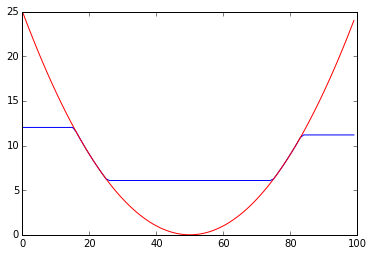

In [10]:

print "It is a test of L1 optimizer for 100 data pts"

y = (np.arange(-5, 5, 0.1)**2)[:,np.newaxis]

start = time.time()
res = L1_C_Filter(y, 100.)
end = time.time()
print "The time it takes is %f seconds " %(end - start)
plt.plot(res, color = 'b')
plt.plot(y, color = 'r')

### $3.$ L1_T_Filter

It is a test of L1 optimizer for 100 data pts
Optimization terminated successfully.    (Exit mode 0)
            Current function value: [-275.62283]
            Iterations: 141
            Function evaluations: 208
            Gradient evaluations: 141
The time it takes is 0.492000 seconds 


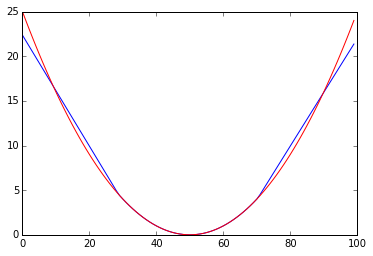

In [11]:
print "It is a test of L1 optimizer for 100 data pts"

y = (np.arange(-5, 5, 0.1)**2)[:,np.newaxis]

start = time.time()
res = L1_T_Filter(y, 200., {'disp': True, 'maxiter': 500})
end = time.time()
print "The time it takes is %f seconds " %(end - start)
plt.plot(res, color = 'b')
plt.plot(y, color = 'r')

### $4.$ L1_TC_Filter

It is a test of L1 optimizer for 100 data pts
Optimization terminated successfully.    (Exit mode 0)
            Current function value: [-454.77897694]
            Iterations: 127
            Function evaluations: 200
            Gradient evaluations: 127
The time it takes is 5.700000 seconds 


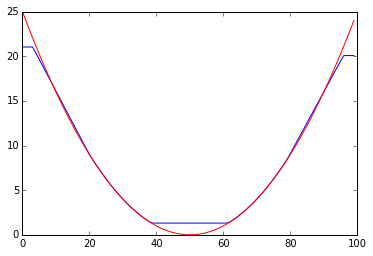

In [30]:
print "It is a test of L1 optimizer for 100 data pts"

y = (np.arange(-5, 5, 0.1)**2)[:,np.newaxis]

start = time.time()
lambd1 = 10.
lambd2 = 10.

res = L1_TC_Filter(y, lambd1, lambd2, {'disp': True, 'maxiter': 500})
end = time.time()
print "The time it takes is %f seconds " %(end - start)
plt.plot(res, color = 'b')
plt.plot(y, color = 'r')

### $5.$ Lambda_Getters

In [21]:
start = time.time()
print Get_T_lambda(y)
print Get_C_lambda(y)
end = time.time()
print "The time it takes is %f seconds " %(end - start)

130206.25001
810.2216
The time it takes is 0.086000 seconds 


### $6.$ CV_Lambda

In [22]:
print "It is a test:"
sig = 10.
y = (np.arange(-5, 5, 0.02)**2)[:,np.newaxis]
y0 = y+ np.random.normal(0, sig, len(y))[:,np.newaxis]

start = time.time()
lam = CV_Lambda(y0, 100, 20, 10, L1_T_Filter, Get_T_lambda, {'disp': False, 'maxiter' : 500})
end = time.time()
print "The time it takes is %f seconds " %(end - start)
print "The final lambda is %f" %lam

It is a test:
lambda is in the range [8.390782, 138.293265]
The time it takes is 22.414000 seconds 
The final lambda is 138.293265


### $7.$ L1_T_Filter with optimal lambda

In [23]:
start = time.time()
x = L1_T_Filter(y0, lam, options = {'disp': True, 'maxiter' : 500})
end = time.time()
print "The time it takes is %f seconds " %(end - start)

Iteration limit exceeded    (Exit mode 9)
            Current function value: [-25237.38605687]
            Iterations: 501
            Function evaluations: 873
            Gradient evaluations: 501
The time it takes is 239.365000 seconds 


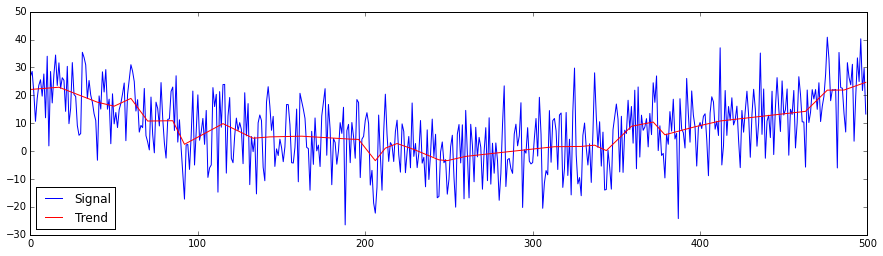

In [16]:
fig, ax = plt.subplots(figsize = (15, 4))
ax.plot(y0, color = 'b', label ='Signal')
ax.plot(x, color = 'r', label = 'Trend')
ax.legend(loc = 'best')

### $8.$ Two_Trend_Predict

In [28]:
print "It is a test:"
sig = 10.
T1 = 70
T2 = 10
T3 = 30
n = 10

y = (np.arange(-5, 5, 0.05)**2)[:,np.newaxis]
y0 = y+ np.random.normal(0, sig, len(y))[:,np.newaxis]

start = time.time()

x = Two_Trend_Predict(y0, T1, T2, T3, n, L1_T_Filter, Get_T_lambda, {'disp': True, 'maxiter' : 500})

end = time.time()
print "The time it takes is %f seconds " %(end - start)

It is a test:
lambda is in the range [-1.013218, 53.613984]
lambda is in the range [-43.080644, 286.330615]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: [-9512.83240134]
            Iterations: 300
            Function evaluations: 447
            Gradient evaluations: 300
Optimization terminated successfully.    (Exit mode 0)
            Current function value: [-9655.13884376]
            Iterations: 338
            Function evaluations: 485
            Gradient evaluations: 338
We will use the short term prediction
The time it takes is 21.771000 seconds 


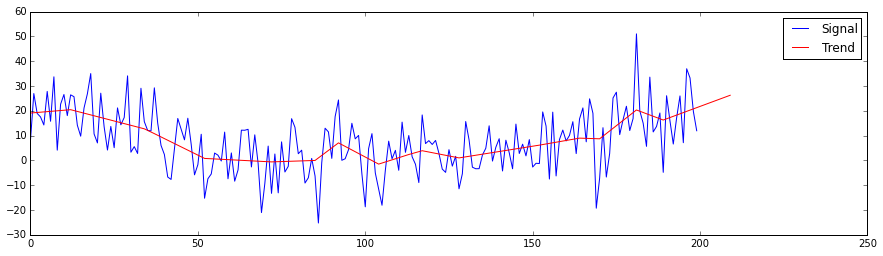

In [29]:
fig, ax = plt.subplots(figsize = (15, 4))
ax.plot(y0, color = 'b', label ='Signal')
ax.plot(x, color = 'r', label = 'Trend')
ax.legend(loc = 'best')